In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from fastai import *
from fastai.text import *

In [3]:
!unzip -qq '/content/drive/My Drive/Analytics Vidhya/input/train.zip'

In [4]:
train_df = pd.read_csv('/content/train.csv')

In [5]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [7]:
train_df['text'] = train_df['TITLE'] + train_df['ABSTRACT']

In [8]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [9]:
!unzip -qq '/content/drive/My Drive/Analytics Vidhya/input/test.zip'

In [10]:
test_df = pd.read_csv('/content/test.csv')

In [11]:
test_df.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [12]:
test_id = test_df['ID']

In [13]:
test_df['text'] = test_df['TITLE'] + test_df['ABSTRACT']

In [14]:
test_df.head()

,ID,TITLE,ABSTRACT,text
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs Fr...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,The $Gaia$-ESO Survey: the inner disk intermed...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,Witness-Functions versus Interpretation-Functi...


In [15]:
%%bash
pip install pytorch-pretrained-bert

In [16]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    "bert-base-uncased",
)

100%|██████████| 231508/231508 [00:00<00:00, 891100.99B/s]


In [17]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [18]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [19]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=256), pre_rules=[], post_rules=[])

In [20]:
label_cols = ['Computer Science', 'Physics' , 'Mathematics' , 'Statistics' , 'Quantitative Biology' , 'Quantitative Finance']

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train, val = train_test_split(train_df, shuffle=True, test_size=0.1, random_state=42)

In [23]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
13275,13276,Clustering in Hilbert space of a quantum optim...,The solution space of many classical optimiz...,1,1,0,0,0,0,Clustering in Hilbert space of a quantum optim...
19273,19274,Graph heat mixture model learning,Graph inference methods have recently attrac...,1,0,0,1,0,0,Graph heat mixture model learning Graph infer...
6427,6428,Fast and unsupervised methods for multilingual...,In this paper we explore the use of unsuperv...,1,0,0,0,0,0,Fast and unsupervised methods for multilingual...
19168,19169,Natasha: Faster Non-Convex Stochastic Optimiza...,Given a nonconvex function that is an averag...,1,0,1,1,0,0,Natasha: Faster Non-Convex Stochastic Optimiza...
14148,14149,Kustaanheimo-Stiefel transformation with an ar...,Kustaanheimo-Stiefel (KS) transformation dep...,0,0,1,0,0,0,Kustaanheimo-Stiefel transformation with an ar...


In [24]:
val.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
20257,20258,Dynamic Layer Normalization for Adaptive Neura...,Layer normalization is a recently introduced...,1,0,0,0,0,0,Dynamic Layer Normalization for Adaptive Neura...
482,483,Susceptibility Propagation by Using Diagonal C...,A susceptibility propagation that is constru...,0,0,1,1,0,0,Susceptibility Propagation by Using Diagonal C...
4189,4190,The Robot Routing Problem for Collecting Aggre...,We propose a new model for formalizing rewar...,1,0,1,0,0,0,The Robot Routing Problem for Collecting Aggre...
9838,9839,"Probability, Statistics and Planet Earth, I: G...",The study of covariances (or positive defini...,0,1,0,1,0,0,"Probability, Statistics and Planet Earth, I: G..."
16591,16592,Counting the number of metastable states in th...,Modularity maximization using greedy algorit...,1,0,0,0,0,0,Counting the number of metastable states in th...


In [25]:
databunch_1 = TextDataBunch.from_df(".", train, val, 
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="text",
                  label_cols=label_cols,
                  bs=16,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [26]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [27]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [28]:
databunch_1.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
"[CLS] the landscape of ne ##uro ##ima ##ge - ing research as the field of ne ##uro ##ima ##ging grows , it can be difficult for scientists within the field to gain and maintain a detailed understanding of its ever - changing landscape . while collaboration and citation networks highlight important contributions within the field , the roles of and relations among specific areas of study can remain quite opaque",Computer Science;Statistics
"[CLS] the spectrum , radiation conditions and the fred ##holm property for the dir ##ich ##let lap ##la ##cian in a per ##for ##ated plane with semi - infinite inclusion ##s we consider the spectral dir ##ich ##let problem for the lap ##lace operator in the plane $ \ omega ^ { \ ci ##rc } $ with double - periodic per ##for ##ation but also in the domain $",Mathematics
[CLS] effects of pressure and magnetic field on the re - en ##tra ##nt super ##con ##du ##ctor eu ( fe $ _ { 0 . 93 } $ r ##h $ _ { 0 . 07 } $ ) $ _ 2 $ as $ _ 2 $ electron - do ##ped eu ( fe $ _ { 0 . 93 } $ r ##h $ _ { 0,Physics
"[CLS] mis ##com ##put ##ation in software : learning to live with errors computer programs do not always work as expected . in fact , ominous warnings about the desperate state of the software industry continue to be released with almost ritual ##istic regular ##ity . in this paper , we look at the 60 years history of programming and at the different practical methods that software community developed to",Computer Science
"[CLS] does a generalized cha ##ply ##gin gas correctly describe the co ##smo ##logical dark sector ? yes , but only for a parameter value that makes it almost coincide with the standard model . we rec ##ons ##ider the co ##smo ##logical dynamics of a generalized cha ##ply ##gin gas ( g ##c ##g ) which is split into a cold dark matter ( cd ##m ) part and",Physics


In [29]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification, BertForNextSentencePrediction, BertForMaskedLM
bert_model_class = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

100%|██████████| 407873900/407873900 [00:11<00:00, 34720219.01B/s]


In [30]:
loss_func = nn.BCEWithLogitsLoss()

In [31]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [32]:
model = bert_model_class

In [33]:
from fastai.callbacks import *

learner = Learner(
    databunch_1, model,
    loss_func=loss_func, model_dir='/content/drive/My Drive/Analytics Vidhya/models/bert', metrics=[acc_02, f1_score],
)

In [34]:
def bert_clas_split(self) -> List[nn.Module]:
    
    bert = model.bert
    embedder = bert.embeddings
    pooler = bert.pooler
    encoder = bert.encoder
    classifier = [model.dropout, model.classifier]
    n = len(encoder.layer)//3
    print(n)
    groups = [[embedder], list(encoder.layer[:n]), list(encoder.layer[n+1:2*n]), list(encoder.layer[(2*n)+1:]), [pooler], classifier]
    return groups

In [35]:
x = bert_clas_split(model)

4


In [36]:
learner.split([x[0], x[1], x[2], x[3], x[5]])

Learner(data=TextClasDataBunch;

Train: LabelList (18874 items)
x: TextList
[CLS] cluster ##ing in hilbert space of a quantum optimization problem the solution space of many classical optimization problems breaks up into clusters which are extensively distant from one another in the ham ##ming metric . here , we show that an analogous quantum cluster ##ing phenomenon takes place in the ground state subsp ##ace of a certain quantum optimization problem . this involves extending the notion of cluster ##ing to hilbert space , where the classical ham ##ming distance is not immediately useful . quantum clusters correspond to macro ##scopic ##ally distinct subsp ##ace ##s of the full quantum ground state space which grow with the system size . we explicitly demonstrate that such clusters arise in the solution space of random quantum sat ##is ##fia ##bility ( 3 - q ##sat ) at its sat ##is ##fia ##bility transition . we estimate both the number of these clusters and their internal entropy . th

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


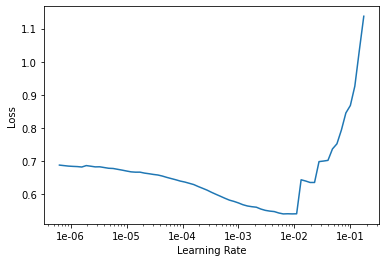

In [37]:
learner.lr_find()
learner.recorder.plot()

In [38]:
learner.fit_one_cycle(3, max_lr=slice(1e-5, 5e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.198767,0.193926,0.901335,0.821174,08:00
1,0.160616,0.168523,0.912456,0.839271,08:16
2,0.128783,0.168149,0.919844,0.849857,08:30


In [39]:
learner.save('head')
learner.load('head')

Learner(data=TextClasDataBunch;

Train: LabelList (18874 items)
x: TextList
[CLS] cluster ##ing in hilbert space of a quantum optimization problem the solution space of many classical optimization problems breaks up into clusters which are extensively distant from one another in the ham ##ming metric . here , we show that an analogous quantum cluster ##ing phenomenon takes place in the ground state subsp ##ace of a certain quantum optimization problem . this involves extending the notion of cluster ##ing to hilbert space , where the classical ham ##ming distance is not immediately useful . quantum clusters correspond to macro ##scopic ##ally distinct subsp ##ace ##s of the full quantum ground state space which grow with the system size . we explicitly demonstrate that such clusters arise in the solution space of random quantum sat ##is ##fia ##bility ( 3 - q ##sat ) at its sat ##is ##fia ##bility transition . we estimate both the number of these clusters and their internal entropy . th

In [40]:
learner.freeze_to(-2)
learner.fit_one_cycle(3, max_lr=slice(1e-4/(2.6**4), 1e-4), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126350,0.172408,0.917382,0.846981,05:47
1,0.117665,0.176549,0.921115,0.851065,05:57
2,0.099948,0.179491,0.921671,0.849889,05:46


In [41]:
learner.save('head-2')
learner.load('head-2')

Learner(data=TextClasDataBunch;

Train: LabelList (18874 items)
x: TextList
[CLS] cluster ##ing in hilbert space of a quantum optimization problem the solution space of many classical optimization problems breaks up into clusters which are extensively distant from one another in the ham ##ming metric . here , we show that an analogous quantum cluster ##ing phenomenon takes place in the ground state subsp ##ace of a certain quantum optimization problem . this involves extending the notion of cluster ##ing to hilbert space , where the classical ham ##ming distance is not immediately useful . quantum clusters correspond to macro ##scopic ##ally distinct subsp ##ace ##s of the full quantum ground state space which grow with the system size . we explicitly demonstrate that such clusters arise in the solution space of random quantum sat ##is ##fia ##bility ( 3 - q ##sat ) at its sat ##is ##fia ##bility transition . we estimate both the number of these clusters and their internal entropy . th

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.31E-07


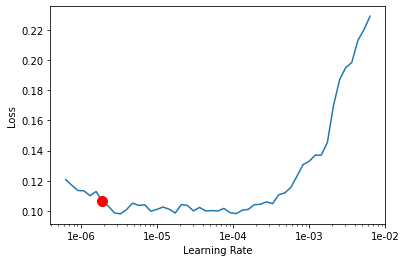

In [42]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [43]:
learner.fit_one_cycle(2, slice(3e-6/(2.6**4), 3e-6), moms=(0.8,0.7), pct_start=0.2, wd =(1e-7, 1e-5, 1e-4, 1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.101703,0.179716,0.921115,0.848999,08:30
1,0.109944,0.179969,0.921354,0.849396,08:38


In [44]:
learner.save('final')

In [45]:
test_datalist = TextList.from_df(test_df, cols='text',
                  vocab=fastai_bert_vocab
                  )

In [46]:
databunch_1.add_test(test_datalist)

# Predict

In [47]:
preds, target = learner.get_preds(DatasetType.Test)
labels = preds.numpy()

submission = pd.DataFrame({'ID': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('/content/drive/My Drive/Analytics Vidhya/output/bert_proba.csv', index=False)
submission.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0.358784,0.001945,0.374500,0.971995,0.000565,4.416108e-04
1,20974,0.001859,0.998249,0.002674,0.001423,0.000135,6.696432e-06
2,20975,0.995202,0.002088,0.020677,0.007275,0.000018,9.835653e-07
3,20976,0.001720,0.998258,0.002757,0.001583,0.000155,7.295190e-06
4,20977,0.994843,0.006588,0.107775,0.002634,0.000032,2.928813e-06
